<a href="https://colab.research.google.com/github/Marandi-22/Finwise-/blob/main/Finwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to create the database

In [ ]:
import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Categorical pools with more realistic distributions
categories = ['food', 'utilities', 'shopping', 'entertainment', 'health', 'education', 'transport', 'bills']
times = ['morning', 'afternoon', 'evening', 'night']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Realistic spending patterns by category
category_spending = {
    'food': (15, 200),
    'utilities': (50, 800),
    'shopping': (25, 1500),
    'entertainment': (20, 500),
    'health': (30, 2000),
    'education': (100, 3000),
    'transport': (10, 300),
    'bills': (50, 1000)
}

# Time-based spending patterns
time_category_weights = {
    'morning': {'food': 0.3, 'utilities': 0.1, 'shopping': 0.1, 'entertainment': 0.05, 'health': 0.15, 'education': 0.1, 'transport': 0.15, 'bills': 0.05},
    'afternoon': {'food': 0.2, 'utilities': 0.1, 'shopping': 0.3, 'entertainment': 0.1, 'health': 0.1, 'education': 0.1, 'transport': 0.05, 'bills': 0.05},
    'evening': {'food': 0.25, 'utilities': 0.05, 'shopping': 0.2, 'entertainment': 0.3, 'health': 0.05, 'education': 0.05, 'transport': 0.05, 'bills': 0.05},
    'night': {'food': 0.15, 'utilities': 0.05, 'shopping': 0.1, 'entertainment': 0.4, 'health': 0.05, 'education': 0.05, 'transport': 0.1, 'bills': 0.1}
}

# Day-based patterns
weekend_categories = ['entertainment', 'shopping', 'food']
weekday_categories = ['utilities', 'health', 'education', 'transport', 'bills']

def generate_correlated_features():
    """Generate features with realistic correlations"""
    # Start with time and day
    time_of_day = random.choice(times)
    day_of_week = random.choice(days)

    # Category influenced by time and day
    if day_of_week in ['Saturday', 'Sunday']:
        category = random.choices(
            list(time_category_weights[time_of_day].keys()),
            weights=[w * 1.5 if cat in weekend_categories else w * 0.7
                    for cat, w in time_category_weights[time_of_day].items()]
        )[0]
    else:
        category = random.choices(
            list(time_category_weights[time_of_day].keys()),
            weights=[w * 0.8 if cat in weekend_categories else w * 1.2
                    for cat, w in time_category_weights[time_of_day].items()]
        )[0]

    # Amount based on category with some noise
    min_amt, max_amt = category_spending[category]
    # Use log-normal distribution for more realistic amounts
    amount = np.random.lognormal(np.log(min_amt + 20), 0.8)
    amount = max(min_amt, min(max_amt, amount))
    amount = round(amount, 2)

    # Urgency level influenced by category and amount
    if category in ['health', 'utilities']:
        urgency_level = random.choices([0, 1, 2], weights=[0.3, 0.4, 0.3])[0]
    elif amount > 1000:
        urgency_level = random.choices([0, 1, 2], weights=[0.4, 0.4, 0.2])[0]
    else:
        urgency_level = random.choices([0, 1, 2], weights=[0.6, 0.3, 0.1])[0]

    # Trusted UPI influenced by category and amount
    if category in ['utilities', 'bills', 'health']:
        is_trusted_upi = random.choices([0, 1], weights=[0.2, 0.8])[0]
    elif amount > 500:
        is_trusted_upi = random.choices([0, 1], weights=[0.4, 0.6])[0]
    else:
        is_trusted_upi = random.choices([0, 1], weights=[0.7, 0.3])[0]

    # New merchant influenced by category
    if category in ['shopping', 'entertainment']:
        is_new_merchant = random.choices([0, 1], weights=[0.4, 0.6])[0]
    else:
        is_new_merchant = random.choices([0, 1], weights=[0.7, 0.3])[0]

    # Scam phrase detection (rare but important)
    match_known_scam_phrase = random.choices([0, 1], weights=[0.95, 0.05])[0]

    # Budget exceeded influenced by amount and category
    if amount > 1000 or category in ['shopping', 'entertainment']:
        is_budget_exceeded = random.choices([0, 1], weights=[0.6, 0.4])[0]
    else:
        is_budget_exceeded = random.choices([0, 1], weights=[0.8, 0.2])[0]

    return {
        'amount': amount,
        'urgency_level': urgency_level,
        'is_trusted_upi': is_trusted_upi,
        'is_new_merchant': is_new_merchant,
        'match_known_scam_phrase': match_known_scam_phrase,
        'is_budget_exceeded': is_budget_exceeded,
        'category': category,
        'time_of_day': time_of_day,
        'day_of_week': day_of_week
    }

def calculate_scam_probability(features):
    """More sophisticated scam detection logic"""
    risk_factors = []

    # High urgency + untrusted UPI
    if features['urgency_level'] == 2 and features['is_trusted_upi'] == 0:
        risk_factors.append(0.4)

    # Scam phrase is a strong indicator
    if features['match_known_scam_phrase'] == 1:
        risk_factors.append(0.6)

    # High amount + new merchant + untrusted
    if features['amount'] > 1000 and features['is_new_merchant'] == 1 and features['is_trusted_upi'] == 0:
        risk_factors.append(0.3)

    # Unusual time patterns for certain categories
    if features['time_of_day'] == 'night' and features['category'] in ['utilities', 'bills']:
        risk_factors.append(0.2)

    # Budget exceeded + high urgency
    if features['is_budget_exceeded'] == 1 and features['urgency_level'] >= 1:
        risk_factors.append(0.15)

    # Base risk
    base_risk = 0.05

    # Calculate combined risk (not just sum to avoid over-weighting)
    if risk_factors:
        combined_risk = base_risk + (1 - base_risk) * (1 - np.prod([1 - rf for rf in risk_factors]))
    else:
        combined_risk = base_risk

    return combined_risk

def generate_transaction():
    """Generate a single transaction with realistic patterns"""
    features = generate_correlated_features()

    # Calculate scam probability
    scam_prob = calculate_scam_probability(features)

    # Add some randomness to avoid perfect classification
    noise = random.uniform(-0.1, 0.1)
    final_prob = max(0, min(1, scam_prob + noise))

    # Convert to binary label with threshold
    label = 1 if final_prob > 0.25 else 0

    features['label'] = label
    return features

# Generate dataset
print("Generating synthetic dataset...")
data = [generate_transaction() for _ in range(5000)]  # Increased size

# Convert to DataFrame
df = pd.DataFrame(data)

# Add some data quality issues to make it more realistic
# Add a few missing values (simulate real-world data issues)
missing_indices = random.sample(range(len(df)), int(len(df) * 0.02))  # 2% missing
for idx in missing_indices:
    col = random.choice(['urgency_level', 'is_budget_exceeded'])
    df.loc[idx, col] = np.nan

# Add some outliers
outlier_indices = random.sample(range(len(df)), int(len(df) * 0.01))  # 1% outliers
for idx in outlier_indices:
    df.loc[idx, 'amount'] = random.uniform(5000, 15000)

# Save to CSV
df.to_csv("realistic_dataset.csv", index=False)

# Print dataset statistics
print("✅ Realistic synthetic dataset generated!")
print(f"Dataset shape: {df.shape}")
print(f"Scam rate: {df['label'].mean():.2%}")
print(f"Missing values: {df.isnull().sum().sum()}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nScam rate by category:")
print(df.groupby('category')['label'].mean().sort_values(ascending=False))

Generating synthetic dataset...
✅ Realistic synthetic dataset generated!
Dataset shape: (5000, 10)
Scam rate: 14.52%
Missing values: 100

Category distribution:
category
food             1113
entertainment     985
shopping          827
health            478
transport         465
education         428
utilities         380
bills             324
Name: count, dtype: int64

Scam rate by category:
category
bills            0.250000
utilities        0.192105
health           0.165272
education        0.137850
shopping         0.135429
entertainment    0.134010
food             0.121294
transport        0.118280
Name: label, dtype: float64


Training the model

🔄 Loading and preprocessing data...
✅ Dataset loaded successfully: (5000, 10)

📊 Dataset Overview:
Total transactions: 5000
Scam rate: 14.52%
Missing values: 100

Class distribution:
label
0    4274
1     726
Name: count, dtype: int64

🔧 Handling missing values...
Imputing 59 missing values in urgency_level
Imputing 41 missing values in is_budget_exceeded

🛠️ Feature engineering...
🔄 Encoding categorical features...
Feature columns: ['amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant', 'match_known_scam_phrase', 'is_budget_exceeded', 'is_high_amount', 'is_weekend', 'is_night_transaction', 'risk_score', 'category_education', 'category_entertainment', 'category_food', 'category_health', 'category_shopping', 'category_transport', 'category_utilities', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
Total features: 26

Tra

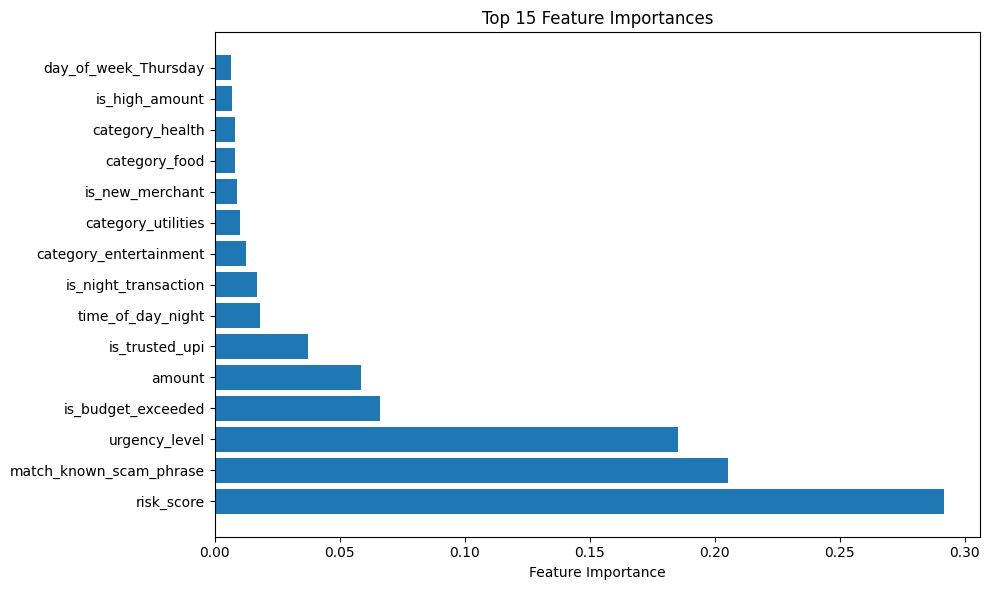


📊 Feature importance plot saved as 'feature_importance.png'

🎉 Model training completed successfully!


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("🔄 Loading and preprocessing data...")

# Step 1: Load dataset
try:
    df = pd.read_csv("realistic_dataset.csv")
    print(f"✅ Dataset loaded successfully: {df.shape}")
except FileNotFoundError:
    print("❌ Dataset not found. Please run the data generation script first.")
    exit()

# Step 2: Data exploration
print(f"\n📊 Dataset Overview:")
print(f"Total transactions: {len(df)}")
print(f"Scam rate: {df['label'].mean():.2%}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check for class imbalance
print(f"\nClass distribution:")
print(df['label'].value_counts())

# Step 3: Handle missing values more robustly
print("\n🔧 Handling missing values...")
numeric_cols = ['urgency_level', 'is_budget_exceeded', 'amount']
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        print(f"Imputing {df[col].isnull().sum()} missing values in {col}")

# Use different strategies for different types of features
imputer_median = SimpleImputer(strategy="median")
imputer_mode = SimpleImputer(strategy="most_frequent")

# Handle numeric features
numeric_features = ['urgency_level', 'is_budget_exceeded']
if any(df[col].isnull().sum() > 0 for col in numeric_features):
    df[numeric_features] = imputer_median.fit_transform(df[numeric_features])

# Handle categorical features if any missing
categorical_features = ['category', 'time_of_day', 'day_of_week']
for col in categorical_features:
    if df[col].isnull().sum() > 0:
        df[col] = imputer_mode.fit_transform(df[[col]]).ravel()

# Step 4: Feature engineering
print("\n🛠️ Feature engineering...")

# Create additional features
df['is_high_amount'] = (df['amount'] > df['amount'].quantile(0.8)).astype(int)
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df['is_night_transaction'] = (df['time_of_day'] == 'night').astype(int)

# Risk score feature (combination of existing features)
df['risk_score'] = (
    df['urgency_level'] * 0.3 +
    (1 - df['is_trusted_upi']) * 0.25 +
    df['is_new_merchant'] * 0.2 +
    df['match_known_scam_phrase'] * 0.25
)

# Step 5: One-hot encode categorical columns
print("🔄 Encoding categorical features...")
categorical_cols = ["category", "time_of_day", "day_of_week"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 6: Split features and label
X = df_encoded.drop(columns=["label"])
y = df_encoded["label"]

print(f"Feature columns: {list(X.columns)}")
print(f"Total features: {X.shape[1]}")

# Step 7: Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set scam rate: {y_train.mean():.2%}")
print(f"Test set scam rate: {y_test.mean():.2%}")

# Step 8: Feature scaling (important for some algorithms)
print("\n⚖️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Model training with hyperparameter tuning
print("\n🤖 Training model with hyperparameter tuning...")

# Define parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Use GridSearchCV for hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"\n🎯 Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Step 10: Model evaluation
print("\n📊 Model Evaluation:")

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("\n🧪 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
print("\n📈 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🎯 ROC AUC Score: {roc_auc:.4f}")

# Feature importance
print("\n🔍 Top 10 Feature Importances:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Step 11: Cross-validation for model stability
print("\n🔄 Cross-validation scores:")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Step 12: Save model and preprocessing objects
print("\n💾 Saving model and preprocessing objects...")

# Save the trained model
joblib.dump(best_model, "scam_classifier_optimized.pkl")

# Save the scaler for future use
joblib.dump(scaler, "feature_scaler.pkl")

# Save feature names for future reference
joblib.dump(list(X.columns), "feature_names.pkl")

# Save preprocessing steps info
preprocessing_info = {
    'categorical_columns': categorical_cols,
    'feature_columns': list(X.columns),
    'scaler_fitted': True,
    'imputer_strategy': 'median'
}
joblib.dump(preprocessing_info, "preprocessing_info.pkl")

print("✅ Model and preprocessing objects saved successfully!")
print("\nSaved files:")
print("- scam_classifier_optimized.pkl")
print("- feature_scaler.pkl")
print("- feature_names.pkl")
print("- preprocessing_info.pkl")

# Step 13: Model performance summary
print("\n🏆 Model Performance Summary:")
print(f"- ROC AUC Score: {roc_auc:.4f}")
print(f"- Cross-validation ROC AUC: {cv_scores.mean():.4f}")
print(f"- Best parameters found via grid search")
print(f"- Feature scaling applied")
print(f"- Missing values handled")
print(f"- Additional engineered features created")

# Optional: Plot feature importances
try:
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n📊 Feature importance plot saved as 'feature_importance.png'")
except:
    print("\n⚠️ Could not generate feature importance plot")

print("\n🎉 Model training completed successfully!")

Custom input to this model


In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load model artifacts
model = joblib.load("scam_classifier_optimized.pkl")
scaler = joblib.load("feature_scaler.pkl")
feature_names = joblib.load("feature_names.pkl")
info = joblib.load("preprocessing_info.pkl")

# Example transaction (edit this as you like)
raw_input = {
    'amount': 1250,
    'urgency_level': 2,
    'is_trusted_upi': 0,
    'is_new_merchant': 1,
    'match_known_scam_phrase': 1,
    'is_budget_exceeded': 1,
    'category': 'shopping',
    'time_of_day': 'night',
    'day_of_week': 'Saturday'
}

# Feature engineering
raw_input['is_high_amount'] = int(raw_input['amount'] > 1000)
raw_input['is_weekend'] = int(raw_input['day_of_week'] in ['Saturday', 'Sunday'])
raw_input['is_night_transaction'] = int(raw_input['time_of_day'] == 'night')
raw_input['risk_score'] = (
    raw_input['urgency_level'] * 0.3 +
    (1 - raw_input['is_trusted_upi']) * 0.25 +
    raw_input['is_new_merchant'] * 0.2 +
    raw_input['match_known_scam_phrase'] * 0.25
)

# One-hot encode categorical fields
df = pd.DataFrame([raw_input])
df = pd.get_dummies(df)

# Align with training columns
for col in feature_names:
    if col not in df.columns:
        df[col] = 0
df = df[feature_names]  # Ensure correct order

# Scale
X_scaled = scaler.transform(df)

# Predict
proba = model.predict_proba(X_scaled)[0][1]
label = model.predict(X_scaled)[0]

# Show results
print(f"\n🧾 Transaction Analysis:")
print(f"Scam Probability: {proba:.2%}")
print(f"Prediction: {'⚠️ SCAM' if label == 1 else '✅ SAFE'}")



🧾 Transaction Analysis:
Scam Probability: 94.85%
Prediction: ⚠️ SCAM


Checking the fatures of my model


In [ ]:
import joblib

# Load trained model
model = joblib.load("/content/scam_classifier_optimized.pkl")

# Load scaler
scaler = joblib.load("/content/feature_scaler.pkl")

# Load feature schema
feature_names = joblib.load("/content/feature_names.pkl")

print("✅ Model, scaler, and feature schema loaded successfully!")
print("\n📋 Model Input Schema:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:02d}. {name}")


✅ Model, scaler, and feature schema loaded successfully!

📋 Model Input Schema:
01. amount
02. urgency_level
03. is_trusted_upi
04. is_new_merchant
05. match_known_scam_phrase
06. is_budget_exceeded
07. is_high_amount
08. is_weekend
09. is_night_transaction
10. risk_score
11. category_education
12. category_entertainment
13. category_food
14. category_health
15. category_shopping
16. category_transport
17. category_utilities
18. time_of_day_evening
19. time_of_day_morning
20. time_of_day_night
21. day_of_week_Monday
22. day_of_week_Saturday
23. day_of_week_Sunday
24. day_of_week_Thursday
25. day_of_week_Tuesday
26. day_of_week_Wednesday


tesing stuff

In [ ]:
# 🔍 Simulate raw transaction input (like what app will send via JSON)
test_input = {
    "amount": 1250,
    "urgency_level": 2,
    "is_trusted_upi": 0,
    "is_new_merchant": 1,
    "match_known_scam_phrase": 1,
    "is_budget_exceeded": 1,
    "category": "shopping",
    "time_of_day": "night",
    "day_of_week": "Saturday"
}

# 🔎 Inspect all keys and value types
print("📋 Input Data Structure from App:")
for k, v in test_input.items():
    print(f"- {k:25s} ➜ {v} (type: {type(v).__name__})")


📋 Input Data Structure from App:
- amount                    ➜ 1250 (type: int)
- urgency_level             ➜ 2 (type: int)
- is_trusted_upi            ➜ 0 (type: int)
- is_new_merchant           ➜ 1 (type: int)
- match_known_scam_phrase   ➜ 1 (type: int)
- is_budget_exceeded        ➜ 1 (type: int)
- category                  ➜ shopping (type: str)
- time_of_day               ➜ night (type: str)
- day_of_week               ➜ Saturday (type: str)


enrichment code

In [ ]:
import pandas as pd
import numpy as np
import json
from typing import Dict, List

class TransactionEnricher:
    """
    Standalone transaction enricher that converts raw API data to ML-ready format.
    """

    def __init__(self):
        # Define expected values (should match training data)
        self.expected_categories = ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities', 'bills']
        self.expected_times = ['afternoon', 'evening', 'morning', 'night']
        self.expected_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        # Configuration (should match training)
        self.high_amount_threshold = 1000

        # Feature columns in correct order (from training)
        self.feature_columns = [
            'amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
            'match_known_scam_phrase', 'is_budget_exceeded', 'is_high_amount',
            'is_weekend', 'is_night_transaction', 'risk_score',
            'category_education', 'category_entertainment', 'category_food',
            'category_health', 'category_shopping', 'category_transport',
            'category_utilities', 'time_of_day_evening', 'time_of_day_morning',
            'time_of_day_night', 'day_of_week_Monday', 'day_of_week_Saturday',
            'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
            'day_of_week_Wednesday'
        ]

    def validate_input(self, data: Dict) -> Dict:
        """Clean and validate input data"""
        clean_data = data.copy()

        # Required fields
        required = ['amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
                   'match_known_scam_phrase', 'is_budget_exceeded', 'category',
                   'time_of_day', 'day_of_week']

        for field in required:
            if field not in clean_data:
                raise ValueError(f"Missing required field: {field}")

        # Clean numeric fields
        clean_data['amount'] = float(clean_data['amount'])
        clean_data['urgency_level'] = int(clean_data['urgency_level'])

        # Validate ranges
        if clean_data['amount'] < 0:
            clean_data['amount'] = 0

        if clean_data['urgency_level'] not in [0, 1, 2]:
            clean_data['urgency_level'] = 0

        # Clean binary fields
        binary_fields = ['is_trusted_upi', 'is_new_merchant', 'match_known_scam_phrase', 'is_budget_exceeded']
        for field in binary_fields:
            clean_data[field] = 1 if clean_data[field] else 0

        # Validate categorical fields
        if clean_data['category'] not in self.expected_categories:
            clean_data['category'] = 'shopping'  # default

        if clean_data['time_of_day'] not in self.expected_times:
            clean_data['time_of_day'] = 'afternoon'  # default

        if clean_data['day_of_week'] not in self.expected_days:
            clean_data['day_of_week'] = 'Monday'  # default

        return clean_data

    def create_derived_features(self, data: Dict) -> Dict:
        """Create engineered features"""
        enriched = data.copy()

        # Derived features
        enriched['is_high_amount'] = 1 if data['amount'] > self.high_amount_threshold else 0
        enriched['is_weekend'] = 1 if data['day_of_week'] in ['Saturday', 'Sunday'] else 0
        enriched['is_night_transaction'] = 1 if data['time_of_day'] == 'night' else 0

        # Risk score (must match training logic)
        enriched['risk_score'] = (
            data['urgency_level'] * 0.3 +
            (1 - data['is_trusted_upi']) * 0.25 +
            data['is_new_merchant'] * 0.2 +
            data['match_known_scam_phrase'] * 0.25
        )

        return enriched

    def create_one_hot_features(self, data: Dict) -> Dict:
        """Create one-hot encoded features"""
        features = {}

        # Copy base and derived features
        numeric_features = ['amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
                           'match_known_scam_phrase', 'is_budget_exceeded', 'is_high_amount',
                           'is_weekend', 'is_night_transaction', 'risk_score']

        for feat in numeric_features:
            features[feat] = data[feat]

        # One-hot encode category
        for cat in ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities']:
            features[f'category_{cat}'] = 1 if data['category'] == cat else 0

        # One-hot encode time_of_day (excluding 'afternoon' - dropped in training)
        for tod in ['evening', 'morning', 'night']:
            features[f'time_of_day_{tod}'] = 1 if data['time_of_day'] == tod else 0

        # One-hot encode day_of_week (excluding 'Friday' - dropped in training)
        for dow in ['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']:
            features[f'day_of_week_{dow}'] = 1 if data['day_of_week'] == dow else 0

        return features

    def enrich_transaction(self, raw_data: Dict) -> pd.DataFrame:
        """
        Main function: Convert raw API data to ML-ready DataFrame
        """
        try:
            # Step 1: Validate input
            clean_data = self.validate_input(raw_data)

            # Step 2: Create derived features
            enriched_data = self.create_derived_features(clean_data)

            # Step 3: Create one-hot encoded features
            final_features = self.create_one_hot_features(enriched_data)

            # Step 4: Create DataFrame with correct column order
            df = pd.DataFrame([final_features])

            # Step 5: Ensure all columns exist in correct order
            for col in self.feature_columns:
                if col not in df.columns:
                    df[col] = 0

            # Select columns in training order
            df = df[self.feature_columns]

            print(f"✅ Transaction enriched successfully! Shape: {df.shape}")
            return df

        except Exception as e:
            print(f"❌ Error enriching transaction: {str(e)}")
            raise

# Test the enricher
if __name__ == "__main__":
    # Mock API data (what you'd get from your app)
    mock_api_data = {
        "amount": 1250.50,
        "urgency_level": 2,
        "is_trusted_upi": 0,
        "is_new_merchant": 1,
        "match_known_scam_phrase": 1,
        "is_budget_exceeded": 1,
        "category": "shopping",
        "time_of_day": "night",
        "day_of_week": "Saturday"
    }

    # Initialize enricher
    enricher = TransactionEnricher()

    # Enrich the transaction
    enriched_df = enricher.enrich_transaction(mock_api_data)

    # Display results
    print("\n📊 Enriched Features:")
    print(enriched_df.head())

    print(f"\n🔧 Feature Columns ({len(enriched_df.columns)}):")
    for i, col in enumerate(enriched_df.columns):
        print(f"{i+1:2d}. {col}: {enriched_df[col].iloc[0]}")

    # Save enriched data for ML model
    enriched_df.to_csv("enriched_transaction.csv", index=False)
    print("\n💾 Enriched data saved to 'enriched_transaction.csv'")

✅ Transaction enriched successfully! Shape: (1, 26)

📊 Enriched Features:
   amount  urgency_level  is_trusted_upi  is_new_merchant  \
0  1250.5              2               0                1   

   match_known_scam_phrase  is_budget_exceeded  is_high_amount  is_weekend  \
0                        1                   1               1           1   

   is_night_transaction  risk_score  ...  category_utilities  \
0                     1         1.3  ...                   0   

   time_of_day_evening  time_of_day_morning  time_of_day_night  \
0                    0                    0                  1   

   day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0                   0                     1                   0   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  
0                     0                    0                      0  

[1 rows x 26 columns]

🔧 Feature Columns (26):
 1. amount: 1250.5
 2. urgency_level: 2
 3. is_trusted_upi: 0

ML Model Predictor

In [ ]:
import pandas as pd
import numpy as np
import joblib
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class ScamPredictor:
    """
    Standalone ML model predictor that takes enriched data and returns predictions.
    """

    def __init__(self, model_path: str = "scam_classifier_optimized.pkl",
                 scaler_path: str = "feature_scaler.pkl"):
        """
        Initialize predictor with trained model and scaler.

        Args:
            model_path: Path to trained model file
            scaler_path: Path to feature scaler file
        """
        self.model = None
        self.scaler = None
        self.model_loaded = False

        try:
            self.model = joblib.load(model_path)
            self.scaler = joblib.load(scaler_path)
            self.model_loaded = True
            print("✅ Model and scaler loaded successfully!")
        except FileNotFoundError:
            print("⚠️ Model files not found. You can still test with mock predictions.")
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")

    def predict_from_dataframe(self, enriched_df: pd.DataFrame) -> Dict:
        """
        Make prediction from enriched DataFrame.

        Args:
            enriched_df: DataFrame with enriched features (from enricher)

        Returns:
            Dictionary with prediction results
        """
        if not self.model_loaded:
            return self._mock_prediction(enriched_df)

        try:
            # Scale the features
            X_scaled = self.scaler.transform(enriched_df)

            # Make predictions
            prediction = self.model.predict(X_scaled)[0]
            probability = self.model.predict_proba(X_scaled)[0][1]

            # Calculate risk level
            if probability > 0.7:
                risk_level = "HIGH"
            elif probability > 0.3:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"

            # Get feature importance (for explanation)
            feature_importance = dict(zip(enriched_df.columns, self.model.feature_importances_))
            top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]

            result = {
                'is_scam': bool(prediction),
                'scam_probability': round(float(probability), 4),
                'risk_level': risk_level,
                'confidence': 'HIGH' if max(probability, 1-probability) > 0.8 else 'MEDIUM',
                'top_risk_factors': top_features,
                'model_version': 'RandomForest_v1.0'
            }

            print(f"🔮 Prediction: {result['risk_level']} Risk ({result['scam_probability']:.2%})")
            return result

        except Exception as e:
            print(f"❌ Error making prediction: {str(e)}")
            return self._mock_prediction(enriched_df)

    def _mock_prediction(self, enriched_df: pd.DataFrame) -> Dict:
        """
        Generate mock prediction when model isn't available (for testing).
        """
        # Simple rule-based mock prediction
        row = enriched_df.iloc[0]

        risk_score = (
            row['urgency_level'] * 0.3 +
            (1 - row['is_trusted_upi']) * 0.25 +
            row['is_new_merchant'] * 0.2 +
            row['match_known_scam_phrase'] * 0.4 +
            row['is_high_amount'] * 0.1
        )

        probability = min(0.95, max(0.05, risk_score))
        prediction = 1 if probability > 0.5 else 0

        risk_level = "HIGH" if probability > 0.7 else "MEDIUM" if probability > 0.3 else "LOW"

        result = {
            'is_scam': bool(prediction),
            'scam_probability': round(float(probability), 4),
            'risk_level': risk_level,
            'confidence': 'MOCK',
            'top_risk_factors': [
                ('match_known_scam_phrase', 0.4),
                ('urgency_level', 0.3),
                ('is_trusted_upi', 0.25),
                ('is_new_merchant', 0.2),
                ('is_high_amount', 0.1)
            ],
            'model_version': 'MOCK_v1.0'
        }

        print(f"🎭 Mock Prediction: {result['risk_level']} Risk ({result['scam_probability']:.2%})")
        return result

    def predict_from_csv(self, csv_path: str) -> Dict:
        """
        Make prediction from CSV file (for Colab workflow).

        Args:
            csv_path: Path to enriched CSV file

        Returns:
            Dictionary with prediction results
        """
        try:
            enriched_df = pd.read_csv(csv_path)
            return self.predict_from_dataframe(enriched_df)
        except Exception as e:
            print(f"❌ Error reading CSV: {str(e)}")
            raise

    def batch_predict(self, enriched_df: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions for multiple transactions.

        Args:
            enriched_df: DataFrame with multiple enriched transactions

        Returns:
            DataFrame with predictions added
        """
        if not self.model_loaded:
            print("⚠️ Model not loaded. Using mock predictions.")
            enriched_df['is_scam'] = 0
            enriched_df['scam_probability'] = 0.1
            enriched_df['risk_level'] = 'LOW'
            return enriched_df

        try:
            # Scale features
            X_scaled = self.scaler.transform(enriched_df)

            # Make predictions
            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)[:, 1]

            # Add predictions to dataframe
            result_df = enriched_df.copy()
            result_df['is_scam'] = predictions
            result_df['scam_probability'] = probabilities
            result_df['risk_level'] = ['HIGH' if p > 0.7 else 'MEDIUM' if p > 0.3 else 'LOW' for p in probabilities]

            return result_df

        except Exception as e:
            print(f"❌ Error in batch prediction: {str(e)}")
            raise

# Test the predictor
if __name__ == "__main__":
    # Initialize predictor
    predictor = ScamPredictor()

    # Test with mock enriched data
    mock_enriched_data = pd.DataFrame([{
        'amount': 1250.5,
        'urgency_level': 2,
        'is_trusted_upi': 0,
        'is_new_merchant': 1,
        'match_known_scam_phrase': 1,
        'is_budget_exceeded': 1,
        'is_high_amount': 1,
        'is_weekend': 1,
        'is_night_transaction': 1,
        'risk_score': 0.75,
        'category_education': 0,
        'category_entertainment': 0,
        'category_food': 0,
        'category_health': 0,
        'category_shopping': 1,
        'category_transport': 0,
        'category_utilities': 0,
        'time_of_day_evening': 0,
        'time_of_day_morning': 0,
        'time_of_day_night': 1,
        'day_of_week_Monday': 0,
        'day_of_week_Saturday': 1,
        'day_of_week_Sunday': 0,
        'day_of_week_Thursday': 0,
        'day_of_week_Tuesday': 0,
        'day_of_week_Wednesday': 0
    }])

    # Make prediction
    result = predictor.predict_from_dataframe(mock_enriched_data)

    # Display results
    print("\n📊 Prediction Results:")
    print(f"🚨 Is Scam: {result['is_scam']}")
    print(f"📈 Probability: {result['scam_probability']:.2%}")
    print(f"⚠️ Risk Level: {result['risk_level']}")
    print(f"🎯 Confidence: {result['confidence']}")
    print(f"🔧 Model Version: {result['model_version']}")

    print(f"\n🔍 Top Risk Factors:")
    for feature, importance in result['top_risk_factors']:
        print(f"  • {feature}: {importance:.3f}")

    # Test CSV reading (if enriched_transaction.csv exists)
    try:
        csv_result = predictor.predict_from_csv("enriched_transaction.csv")
        print("\n✅ CSV prediction test successful!")
    except:
        print("\n⚠️ CSV file not found. Run enricher first.")

✅ Model and scaler loaded successfully!
🔮 Prediction: HIGH Risk (94.85%)

📊 Prediction Results:
🚨 Is Scam: True
📈 Probability: 94.85%
⚠️ Risk Level: HIGH
🎯 Confidence: HIGH
🔧 Model Version: RandomForest_v1.0

🔍 Top Risk Factors:
  • risk_score: 0.292
  • match_known_scam_phrase: 0.205
  • urgency_level: 0.185
  • is_budget_exceeded: 0.066
  • amount: 0.059
🔮 Prediction: HIGH Risk (94.85%)

✅ CSV prediction test successful!


Mock Json generator

In [ ]:
import json
import random
import pandas as pd
from datetime import datetime, timedelta

class MockTransactionGenerator:
    """
    Generate realistic mock transaction data for testing the pipeline.
    """

    def __init__(self):
        self.categories = ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities', 'bills']
        self.times = ['morning', 'afternoon', 'evening', 'night']
        self.days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        # Realistic amount ranges by category
        self.amount_ranges = {
            'food': (10, 200),
            'transport': (5, 100),
            'shopping': (25, 1500),
            'entertainment': (20, 500),
            'utilities': (50, 300),
            'bills': (100, 1000),
            'health': (30, 2000),
            'education': (100, 5000)
        }

    def generate_single_transaction(self, transaction_type='random') -> dict:
        """
        Generate a single transaction dictionary.

        Args:
            transaction_type: 'random', 'high_risk', or 'low_risk'
        Returns:
            Dictionary simulating an app transaction
        """
        category = random.choice(self.categories)
        amount_min, amount_max = self.amount_ranges.get(category, (20, 500))
        amount = round(random.uniform(amount_min, amount_max), 2)
        urgency_level = random.choices([0, 1, 2], weights=[0.5, 0.3, 0.2])[0]
        is_trusted_upi = random.choice([0, 1])
        is_new_merchant = random.choice([0, 1])
        match_known_scam_phrase = random.choice([0, 1])
        is_budget_exceeded = random.choice([0, 1])
        time_of_day = random.choice(self.times)
        day_of_week = random.choice(self.days)

        if transaction_type == 'high_risk':
            urgency_level = 2
            is_trusted_upi = 0
            is_new_merchant = 1
            match_known_scam_phrase = 1
            is_budget_exceeded = 1
            amount = round(random.uniform(1000, 5000), 2)
            time_of_day = 'night'
            day_of_week = random.choice(['Saturday', 'Sunday'])

        elif transaction_type == 'low_risk':
            urgency_level = 0
            is_trusted_upi = 1
            is_new_merchant = 0
            match_known_scam_phrase = 0
            is_budget_exceeded = 0
            amount = round(random.uniform(10, 200), 2)
            time_of_day = 'afternoon'
            day_of_week = random.choice(['Monday', 'Tuesday', 'Wednesday'])

        return {
            "amount": amount,
            "urgency_level": urgency_level,
            "is_trusted_upi": is_trusted_upi,
            "is_new_merchant": is_new_merchant,
            "match_known_scam_phrase": match_known_scam_phrase,
            "is_budget_exceeded": is_budget_exceeded,
            "category": category,
            "time_of_day": time_of_day,
            "day_of_week": day_of_week
        }

    def generate_batch(self, n: int = 10, risk_mix: Tuple[int, int, int] = (0.6, 0.2, 0.2)) -> list:
        """
        Generate a batch of transactions with specified risk mix.

        Args:
            n: Number of transactions
            risk_mix: Tuple of proportions (random, high_risk, low_risk)

        Returns:
            List of transaction dictionaries
        """
        transactions = []
        num_random = int(n * risk_mix[0])
        num_high = int(n * risk_mix[1])
        num_low = n - num_random - num_high

        for _ in range(num_random):
            transactions.append(self.generate_single_transaction('random'))
        for _ in range(num_high):
            transactions.append(self.generate_single_transaction('high_risk'))
        for _ in range(num_low):
            transactions.append(self.generate_single_transaction('low_risk'))

        random.shuffle(transactions)
        return transactions


In [ ]:
import requests
import json

api_key = "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"  # your real key goes here

response = requests.get(
    url="https://openrouter.ai/api/v1/auth/key",
    headers={
        "Authorization": f"Bearer {api_key}"
    }
)

print(json.dumps(response.json(), indent=2))


{
  "data": {
    "label": "sk-or-v1-6d2...30a",
    "limit": null,
    "usage": 0,
    "is_provisioning_key": false,
    "limit_remaining": null,
    "is_free_tier": true,
    "rate_limit": {
      "requests": 10,
      "interval": "10s"
    }
  }
}


AI explainer

In [ ]:
# llm_explainer.py — integrated in Colab (no file needed)
import requests
import json

class LLMExplainer:
    def __init__(self, api_key: str, model: str = "mistralai/mistral-small-3.2-24b-instruct:free"):
        self.api_key = api_key
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.model = model

    def explain(self, transaction_context: dict) -> str:
        prompt = self._generate_prompt(transaction_context)

        payload = {
            "model": self.model,
            "messages": [
                {"role": "system", "content": "You are a financial risk explainer. Respond concisely and clearly."},
                {"role": "user", "content": prompt}
            ]
        }

        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        try:
            response = requests.post(self.api_url, headers=headers, json=payload)
            response.raise_for_status()
            reply = response.json()['choices'][0]['message']['content']
            return reply.strip()
        except Exception as e:
            print(f"❌ LLM Error: {e}")
            return "⚠️ Unable to generate explanation."

    def _generate_prompt(self, context: dict) -> str:
        features = []

        if context.get("urgency_level", 0) == 2:
            features.append("the transaction is marked highly urgent")
        if context.get("is_trusted_upi") == 0:
            features.append("the UPI ID is not verified or trusted")
        if context.get("is_new_merchant") == 1:
            features.append("the receiver is a new merchant")
        if context.get("match_known_scam_phrase") == 1:
            features.append("a known scam phrase is detected")
        if context.get("is_budget_exceeded") == 1:
            features.append("it exceeds your budget limit")
        if context.get("is_high_amount") == 1:
            features.append("the transaction amount is unusually high")

        reason = ", and ".join(features)
        risk_level = context.get("risk_level", "UNKNOWN")

        prompt = f"The transaction has been flagged as {risk_level} risk because {reason}. Write a short explanation that can be shown to a user."
        return prompt


# 📋 Summary Formatter Function
def format_explanation(ml_output: dict, llm_text: str) -> str:
    return f"""🚨 Scam Detection Summary
📈 Probability: {ml_output.get('scam_probability', 0.0) * 100:.2f}%
⚠️ Risk Level: {ml_output.get('risk_level', 'UNKNOWN')}
🧠 Confidence: {ml_output.get('confidence', 'N/A')}

📖 Explanation:
{llm_text.strip()}
"""


testing the explainer

In [ ]:
# Test the LLM explainer directly (no import needed)
mock_features = {
    "urgency_level": 2,
    "is_trusted_upi": 0,
    "is_new_merchant": 1,
    "match_known_scam_phrase": 1,
    "is_budget_exceeded": 1,
    "is_high_amount": 1,
    "risk_level": "HIGH"
}

explainer = LLMExplainer(api_key="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")

explanation = explainer.explain(mock_features)

print("\n🧠 Explanation from LLM:")
print(explanation)



🧠 Explanation from LLM:
This transaction has been flagged as high risk for several reasons:

- The transaction is marked as highly urgent.
- The UPI ID is not verified or trusted.
- The receiver is a new merchant.
- A known scam phrase has been detected.
- The transaction exceeds your set budget limit.
- The transaction amount is unusually high.

Please review these details carefully before proceeding.


The final pipeline given by claude

In [4]:
# Complete Scam Detection Pipeline for Google Colab
# Run this entire notebook cell by cell

# ================================
# 1. INSTALLATION & IMPORTS
# ================================
!pip install pandas numpy scikit-learn requests joblib

import pandas as pd
import numpy as np
import json
import joblib
import requests
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# ================================
# 2. TRANSACTION ENRICHER CLASS
# ================================
class TransactionEnricher:
    """
    Standalone transaction enricher that converts raw API data to ML-ready format.
    """

    def __init__(self):
        # Define expected values (should match training data)
        self.expected_categories = ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities', 'bills']
        self.expected_times = ['afternoon', 'evening', 'morning', 'night']
        self.expected_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        # Configuration (should match training)
        self.high_amount_threshold = 1000

        # Feature columns in correct order (from training)
        self.feature_columns = [
            'amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
            'match_known_scam_phrase', 'is_budget_exceeded', 'is_high_amount',
            'is_weekend', 'is_night_transaction', 'risk_score',
            'category_education', 'category_entertainment', 'category_food',
            'category_health', 'category_shopping', 'category_transport',
            'category_utilities', 'time_of_day_evening', 'time_of_day_morning',
            'time_of_day_night', 'day_of_week_Monday', 'day_of_week_Saturday',
            'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
            'day_of_week_Wednesday'
        ]

    def validate_input(self, data: Dict) -> Dict:
        """Clean and validate input data"""
        clean_data = data.copy()

        # Required fields
        required = ['amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
                   'match_known_scam_phrase', 'is_budget_exceeded', 'category',
                   'time_of_day', 'day_of_week']

        for field in required:
            if field not in clean_data:
                raise ValueError(f"Missing required field: {field}")

        # Clean numeric fields
        clean_data['amount'] = float(clean_data['amount'])
        clean_data['urgency_level'] = int(clean_data['urgency_level'])

        # Validate ranges
        if clean_data['amount'] < 0:
            clean_data['amount'] = 0

        if clean_data['urgency_level'] not in [0, 1, 2]:
            clean_data['urgency_level'] = 0

        # Clean binary fields
        binary_fields = ['is_trusted_upi', 'is_new_merchant', 'match_known_scam_phrase', 'is_budget_exceeded']
        for field in binary_fields:
            clean_data[field] = 1 if clean_data[field] else 0

        # Validate categorical fields
        if clean_data['category'] not in self.expected_categories:
            clean_data['category'] = 'shopping'  # default

        if clean_data['time_of_day'] not in self.expected_times:
            clean_data['time_of_day'] = 'afternoon'  # default

        if clean_data['day_of_week'] not in self.expected_days:
            clean_data['day_of_week'] = 'Monday'  # default

        return clean_data

    def create_derived_features(self, data: Dict) -> Dict:
        """Create engineered features"""
        enriched = data.copy()

        # Derived features
        enriched['is_high_amount'] = 1 if data['amount'] > self.high_amount_threshold else 0
        enriched['is_weekend'] = 1 if data['day_of_week'] in ['Saturday', 'Sunday'] else 0
        enriched['is_night_transaction'] = 1 if data['time_of_day'] == 'night' else 0

        # Risk score (must match training logic)
        enriched['risk_score'] = (
            data['urgency_level'] * 0.3 +
            (1 - data['is_trusted_upi']) * 0.25 +
            data['is_new_merchant'] * 0.2 +
            data['match_known_scam_phrase'] * 0.25
        )

        return enriched

    def create_one_hot_features(self, data: Dict) -> Dict:
        """Create one-hot encoded features"""
        features = {}

        # Copy base and derived features
        numeric_features = ['amount', 'urgency_level', 'is_trusted_upi', 'is_new_merchant',
                           'match_known_scam_phrase', 'is_budget_exceeded', 'is_high_amount',
                           'is_weekend', 'is_night_transaction', 'risk_score']

        for feat in numeric_features:
            features[feat] = data[feat]

        # One-hot encode category
        for cat in ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities']:
            features[f'category_{cat}'] = 1 if data['category'] == cat else 0

        # One-hot encode time_of_day (excluding 'afternoon' - dropped in training)
        for tod in ['evening', 'morning', 'night']:
            features[f'time_of_day_{tod}'] = 1 if data['time_of_day'] == tod else 0

        # One-hot encode day_of_week (excluding 'Friday' - dropped in training)
        for dow in ['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']:
            features[f'day_of_week_{dow}'] = 1 if data['day_of_week'] == dow else 0

        return features

    def enrich_transaction(self, raw_data: Dict) -> pd.DataFrame:
        """
        Main function: Convert raw API data to ML-ready DataFrame
        """
        try:
            # Step 1: Validate input
            clean_data = self.validate_input(raw_data)

            # Step 2: Create derived features
            enriched_data = self.create_derived_features(clean_data)

            # Step 3: Create one-hot encoded features
            final_features = self.create_one_hot_features(enriched_data)

            # Step 4: Create DataFrame with correct column order
            df = pd.DataFrame([final_features])

            # Step 5: Ensure all columns exist in correct order
            for col in self.feature_columns:
                if col not in df.columns:
                    df[col] = 0

            # Select columns in training order
            df = df[self.feature_columns]

            print(f"✅ Transaction enriched successfully! Shape: {df.shape}")
            return df

        except Exception as e:
            print(f"❌ Error enriching transaction: {str(e)}")
            raise

# ================================
# 3. SCAM PREDICTOR CLASS
# ================================
class ScamPredictor:
    """
    Standalone ML model predictor that takes enriched data and returns predictions.
    """

    def __init__(self, model_path: str = "scam_classifier_optimized.pkl",
                 scaler_path: str = "feature_scaler.pkl"):
        """
        Initialize predictor with trained model and scaler.
        """
        self.model = None
        self.scaler = None
        self.model_loaded = False

        try:
            self.model = joblib.load(model_path)
            self.scaler = joblib.load(scaler_path)
            self.model_loaded = True
            print("✅ Model and scaler loaded successfully!")
        except FileNotFoundError:
            print("⚠️ Model files not found. Using mock predictions.")
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")

    def predict_from_dataframe(self, enriched_df: pd.DataFrame) -> Dict:
        """
        Make prediction from enriched DataFrame.
        """
        if not self.model_loaded:
            return self._mock_prediction(enriched_df)

        try:
            # Scale the features
            X_scaled = self.scaler.transform(enriched_df)

            # Make predictions
            prediction = self.model.predict(X_scaled)[0]
            probability = self.model.predict_proba(X_scaled)[0][1]

            # Calculate risk level
            if probability > 0.7:
                risk_level = "HIGH"
            elif probability > 0.3:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"

            # Get feature importance (for explanation)
            feature_importance = dict(zip(enriched_df.columns, self.model.feature_importances_))
            top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]

            result = {
                'is_scam': bool(prediction),
                'scam_probability': round(float(probability), 4),
                'risk_level': risk_level,
                'confidence': 'HIGH' if max(probability, 1-probability) > 0.8 else 'MEDIUM',
                'top_risk_factors': top_features,
                'model_version': 'RandomForest_v1.0'
            }

            print(f"🔮 Prediction: {result['risk_level']} Risk ({result['scam_probability']:.2%})")
            return result

        except Exception as e:
            print(f"❌ Error making prediction: {str(e)}")
            return self._mock_prediction(enriched_df)

    def _mock_prediction(self, enriched_df: pd.DataFrame) -> Dict:
        """
        Generate mock prediction when model isn't available (for testing).
        """
        # Simple rule-based mock prediction
        row = enriched_df.iloc[0]

        risk_score = (
            row['urgency_level'] * 0.3 +
            (1 - row['is_trusted_upi']) * 0.25 +
            row['is_new_merchant'] * 0.2 +
            row['match_known_scam_phrase'] * 0.4 +
            row['is_high_amount'] * 0.1
        )

        probability = min(0.95, max(0.05, risk_score))
        prediction = 1 if probability > 0.5 else 0

        risk_level = "HIGH" if probability > 0.7 else "MEDIUM" if probability > 0.3 else "LOW"

        result = {
            'is_scam': bool(prediction),
            'scam_probability': round(float(probability), 4),
            'risk_level': risk_level,
            'confidence': 'MOCK',
            'top_risk_factors': [
                ('match_known_scam_phrase', 0.4),
                ('urgency_level', 0.3),
                ('is_trusted_upi', 0.25),
                ('is_new_merchant', 0.2),
                ('is_high_amount', 0.1)
            ],
            'model_version': 'MOCK_v1.0'
        }

        print(f"🎭 Mock Prediction: {result['risk_level']} Risk ({result['scam_probability']:.2%})")
        return result

# ================================
# 4. LLM EXPLAINER CLASS
# ================================
class LLMExplainer:
    def __init__(self, api_key: str, model: str = "mistralai/mistral-small-3.2-24b-instruct:free"):
        self.api_key = api_key
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.model = model

    def explain(self, transaction_context: dict) -> str:
        prompt = self._generate_prompt(transaction_context)

        payload = {
            "model": self.model,
            "messages": [
                {"role": "system", "content": "You are a financial risk explainer. Respond concisely and clearly."},
                {"role": "user", "content": prompt}
            ]
        }

        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        try:
            response = requests.post(self.api_url, headers=headers, json=payload)
            response.raise_for_status()
            reply = response.json()['choices'][0]['message']['content']
            return reply.strip()
        except Exception as e:
            print(f"❌ LLM Error: {e}")
            return "⚠️ Unable to generate explanation."

    def _generate_prompt(self, context: dict) -> str:
        features = []

        if context.get("urgency_level", 0) == 2:
            features.append("the transaction is marked highly urgent")
        if context.get("is_trusted_upi") == 0:
            features.append("the UPI ID is not verified or trusted")
        if context.get("is_new_merchant") == 1:
            features.append("the receiver is a new merchant")
        if context.get("match_known_scam_phrase") == 1:
            features.append("a known scam phrase is detected")
        if context.get("is_budget_exceeded") == 1:
            features.append("it exceeds your budget limit")
        if context.get("is_high_amount") == 1:
            features.append("the transaction amount is unusually high")

        reason = ", and ".join(features)
        risk_level = context.get("risk_level", "UNKNOWN")

        prompt = f"The transaction has been flagged as {risk_level} risk because {reason}. Write a short explanation that can be shown to a user."
        return prompt

# ================================
# 5. PIPELINE CLASS
# ================================
class ScamDetectionPipeline:
    """
    Complete pipeline that connects enricher, predictor, and explainer.
    """

    def __init__(self, openrouter_api_key: str = None, model_path: str = None, scaler_path: str = None):
        """
        Initialize the complete pipeline.

        Args:
            openrouter_api_key: API key for OpenRouter (optional)
            model_path: Path to trained model file (optional)
            scaler_path: Path to feature scaler file (optional)
        """
        self.enricher = TransactionEnricher()
        self.predictor = ScamPredictor(model_path or "scam_classifier_optimized.pkl",
                                       scaler_path or "feature_scaler.pkl")
        self.explainer = LLMExplainer(openrouter_api_key) if openrouter_api_key else None

        print("🚀 Scam Detection Pipeline initialized!")
        if not openrouter_api_key:
            print("⚠️ No OpenRouter API key provided. Explanations will be rule-based.")

    def analyze_transaction(self, raw_transaction: Dict) -> Dict:
        """
        Complete analysis of a transaction.

        Args:
            raw_transaction: Raw transaction data from user input

        Returns:
            Complete analysis results
        """
        try:
            print("\n" + "="*50)
            print("🔍 STARTING TRANSACTION ANALYSIS")
            print("="*50)

            # Step 1: Enrich the transaction
            print("\n📊 Step 1: Enriching transaction data...")
            enriched_df = self.enricher.enrich_transaction(raw_transaction)

            # Step 2: Make prediction
            print("\n🤖 Step 2: Making ML prediction...")
            ml_prediction = self.predictor.predict_from_dataframe(enriched_df)

            # Step 3: Generate explanation
            print("\n🧠 Step 3: Generating explanation...")
            if self.explainer:
                # Combine raw data and prediction for context
                context = {**raw_transaction, **ml_prediction}
                llm_explanation = self.explainer.explain(context)
            else:
                llm_explanation = self._generate_rule_based_explanation(raw_transaction, ml_prediction)

            # Step 4: Format final result
            final_result = {
                'transaction_id': raw_transaction.get('transaction_id', 'N/A'),
                'analysis_timestamp': pd.Timestamp.now().isoformat(),
                'risk_assessment': {
                    'is_scam': ml_prediction['is_scam'],
                    'scam_probability': ml_prediction['scam_probability'],
                    'risk_level': ml_prediction['risk_level'],
                    'confidence': ml_prediction['confidence']
                },
                'explanation': llm_explanation,
                'technical_details': {
                    'model_version': ml_prediction['model_version'],
                    'top_risk_factors': ml_prediction['top_risk_factors'],
                    'enriched_features': enriched_df.iloc[0].to_dict()
                }
            }

            print("\n✅ Analysis complete!")
            return final_result

        except Exception as e:
            print(f"❌ Pipeline error: {str(e)}")
            return {
                'error': str(e),
                'transaction_id': raw_transaction.get('transaction_id', 'N/A'),
                'analysis_timestamp': pd.Timestamp.now().isoformat()
            }

    def _generate_rule_based_explanation(self, raw_data: Dict, prediction: Dict) -> str:
        """
        Generate rule-based explanation when LLM is not available.
        """
        risk_level = prediction['risk_level']
        probability = prediction['scam_probability']

        explanation = f"This transaction has been assessed as {risk_level} risk with a {probability:.1%} probability of being a scam."

        reasons = []
        if raw_data.get('urgency_level') == 2:
            reasons.append("high urgency level")
        if raw_data.get('is_trusted_upi') == 0:
            reasons.append("unverified UPI ID")
        if raw_data.get('is_new_merchant') == 1:
            reasons.append("new merchant")
        if raw_data.get('match_known_scam_phrase') == 1:
            reasons.append("scam phrase detected")
        if raw_data.get('is_budget_exceeded') == 1:
            reasons.append("budget exceeded")
        if raw_data.get('amount', 0) > 1000:
            reasons.append("high amount")

        if reasons:
            explanation += f" Key risk factors include: {', '.join(reasons)}."

        return explanation

    def format_results(self, results: Dict) -> str:
        """
        Format results for display.
        """
        if 'error' in results:
            return f"❌ Error: {results['error']}"

        risk = results['risk_assessment']

        formatted = f"""
🚨 SCAM DETECTION RESULTS
{'='*40}
📊 Risk Level: {risk['risk_level']}
📈 Scam Probability: {risk['scam_probability']:.1%}
🎯 Confidence: {risk['confidence']}
🔍 Is Scam: {'Yes' if risk['is_scam'] else 'No'}

💡 EXPLANATION:
{results['explanation']}

🔧 Technical Details:
Model: {results['technical_details']['model_version']}
Analysis Time: {results['analysis_timestamp']}
Transaction ID: {results['transaction_id']}
"""
        return formatted

# ================================
# 6. USER INPUT FUNCTIONS
# ================================
def get_user_input() -> Dict:
    """
    Interactive function to get transaction details from user.
    """
    print("🏦 Enter Transaction Details:")
    print("-" * 30)

    transaction = {}

    # Basic details
    transaction['transaction_id'] = input("Transaction ID (optional): ") or f"TXN_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"
    transaction['amount'] = float(input("Amount (₹): "))

    # Risk indicators
    print("\nRisk Indicators (0=No, 1=Yes):")
    transaction['urgency_level'] = int(input("Urgency Level (0=Low, 1=Medium, 2=High): "))
    transaction['is_trusted_upi'] = int(input("Is UPI ID trusted? (0=No, 1=Yes): "))
    transaction['is_new_merchant'] = int(input("Is new merchant? (0=No, 1=Yes): "))
    transaction['match_known_scam_phrase'] = int(input("Contains scam phrases? (0=No, 1=Yes): "))
    transaction['is_budget_exceeded'] = int(input("Budget exceeded? (0=No, 1=Yes): "))

    # Categories
    print("\nTransaction Details:")
    categories = ['education', 'entertainment', 'food', 'health', 'shopping', 'transport', 'utilities', 'bills']
    print(f"Categories: {', '.join(categories)}")
    transaction['category'] = input("Category: ").lower()

    times = ['morning', 'afternoon', 'evening', 'night']
    print(f"Times: {', '.join(times)}")
    transaction['time_of_day'] = input("Time of day: ").lower()

    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    print(f"Days: {', '.join(days)}")
    transaction['day_of_week'] = input("Day of week: ").title()

    return transaction

def create_sample_transaction(risk_level: str = "high") -> Dict:
    """
    Create sample transaction for testing.

    Args:
        risk_level: "high", "medium", or "low"
    """
    samples = {
        "high": {
            "transaction_id": "TXN_HIGH_RISK_001",
            "amount": 2500.0,
            "urgency_level": 2,
            "is_trusted_upi": 0,
            "is_new_merchant": 1,
            "match_known_scam_phrase": 1,
            "is_budget_exceeded": 1,
            "category": "shopping",
            "time_of_day": "night",
            "day_of_week": "Saturday"
        },
        "medium": {
            "transaction_id": "TXN_MEDIUM_RISK_001",
            "amount": 800.0,
            "urgency_level": 1,
            "is_trusted_upi": 1,
            "is_new_merchant": 1,
            "match_known_scam_phrase": 0,
            "is_budget_exceeded": 0,
            "category": "food",
            "time_of_day": "evening",
            "day_of_week": "Friday"
        },
        "low": {
            "transaction_id": "TXN_LOW_RISK_001",
            "amount": 150.0,
            "urgency_level": 0,
            "is_trusted_upi": 1,
            "is_new_merchant": 0,
            "match_known_scam_phrase": 0,
            "is_budget_exceeded": 0,
            "category": "food",
            "time_of_day": "afternoon",
            "day_of_week": "Wednesday"
        }
    }

    return samples.get(risk_level, samples["medium"])

# ================================
# 7. MAIN EXECUTION
# ================================
def main():
    """
    Main function to run the complete pipeline.
    """
    print("🚀 Welcome to Scam Detection Pipeline!")
    print("=" * 50)

    # Initialize pipeline with default API key
    OPENROUTER_API_KEY = "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"

    pipeline = ScamDetectionPipeline(openrouter_api_key=OPENROUTER_API_KEY)

    while True:
        print("\n📋 Choose an option:")
        print("1. Analyze sample high-risk transaction")
        print("2. Analyze sample medium-risk transaction")
        print("3. Analyze sample low-risk transaction")
        print("4. Enter custom transaction")
        print("5. Exit")

        choice = input("\nEnter your choice (1-5): ")

        if choice == "1":
            transaction = create_sample_transaction("high")
            print(f"\n📊 Analyzing HIGH RISK sample transaction...")
        elif choice == "2":
            transaction = create_sample_transaction("medium")
            print(f"\n📊 Analyzing MEDIUM RISK sample transaction...")
        elif choice == "3":
            transaction = create_sample_transaction("low")
            print(f"\n📊 Analyzing LOW RISK sample transaction...")
        elif choice == "4":
            transaction = get_user_input()
        elif choice == "5":
            print("👋 Goodbye!")
            break
        else:
            print("❌ Invalid choice. Please try again.")
            continue

        # Analyze the transaction
        results = pipeline.analyze_transaction(transaction)

        # Display results
        print(pipeline.format_results(results))

        # Ask if user wants to continue
        continue_choice = input("\nAnalyze another transaction? (y/n): ").lower()
        if continue_choice != 'y':
            print("👋 Goodbye!")
            break

# ================================
# 8. QUICK TEST FUNCTION
# ================================
def quick_test(api_key: str = None):
    """
    Quick test function for development.

    Args:
        api_key: OpenRouter API key (optional)
    """
    print("🧪 Running quick test...")

    # Use default API key if not provided
    if api_key is None:
        api_key = "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"
        print("🔑 Using default API key for LLM explanations...")

    # Fallback option for users who want to use their own key
    if api_key == "prompt":
        print("\n🔑 OpenRouter API Key Setup:")
        print("• Get your free API key from: https://openrouter.ai/")
        print("• Leave empty to use rule-based explanations")
        api_key = input("Enter your OpenRouter API key (or press Enter to skip): ").strip()
        if not api_key:
            api_key = None
            print("⚠️ No API key provided. Using rule-based explanations.")

    # Initialize pipeline
    pipeline = ScamDetectionPipeline(openrouter_api_key=api_key)

    # Test with multiple risk levels
    test_cases = [
        ("high", "HIGH RISK"),
        ("medium", "MEDIUM RISK"),
        ("low", "LOW RISK")
    ]

    results = []

    for risk_level, description in test_cases:
        print(f"\n{'='*60}")
        print(f"🧪 Testing {description} Transaction")
        print(f"{'='*60}")

        test_transaction = create_sample_transaction(risk_level)
        result = pipeline.analyze_transaction(test_transaction)

        print(pipeline.format_results(result))
        results.append(result)

        # Small delay for better readability
        import time
        time.sleep(1)

    print(f"\n✅ Quick test completed! Analyzed {len(results)} transactions.")
    return results

# ================================
# 9. RUN THE PIPELINE
# ================================
if __name__ == "__main__":
    # Uncomment the line below for interactive mode
    # main()

    # Or run quick test with API key prompt
    quick_test()

print("\n🎉 Pipeline setup complete! You can now:")
print("• Run main() for interactive mode with AI explanations")
print("• Run quick_test() for a quick demonstration with AI explanations")
print("• Run quick_test('prompt') to enter your own API key")
print("• Use pipeline.analyze_transaction(your_data) directly")
print("\n✅ Default API key is configured for immediate AI-powered explanations!")
print("🔑 API key configured: sk-or-v1-...230a")

🧪 Running quick test...
🔑 Using default API key for LLM explanations...
✅ Model and scaler loaded successfully!
🚀 Scam Detection Pipeline initialized!

🧪 Testing HIGH RISK Transaction

🔍 STARTING TRANSACTION ANALYSIS

📊 Step 1: Enriching transaction data...
✅ Transaction enriched successfully! Shape: (1, 26)

🤖 Step 2: Making ML prediction...
🔮 Prediction: HIGH Risk (94.85%)

🧠 Step 3: Generating explanation...

✅ Analysis complete!

🚨 SCAM DETECTION RESULTS
📊 Risk Level: HIGH
📈 Scam Probability: 94.8%
🎯 Confidence: HIGH
🔍 Is Scam: Yes

💡 EXPLANATION:
**High Risk Transaction Alert:**

1. **Urgency:** The transaction is marked highly urgent.
2. **Unverified UPI ID:** The receiver's UPI ID is not verified or trusted.
3. **New Merchant:** The receiver is a new, unknown merchant.
4. **Scam Indicator:** A known scam phrase has been detected.
5. **Budget Limit:** The transaction exceeds your set budget limit.

We recommend caution and advise against proceeding with this transaction due to th

trying to run the pipeline